In [1]:
!pip install pandas_ta
!pip install neat-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=03045e5278915f0f68ee70d84a91097db4fa2cac7f0378e0208d0bf3b9483c80
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 4.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
use_collab = True
if use_collab:
  csv_dir = '/content/drive/MyDrive/eurusd_hour.csv'
  config_dir = '/content/drive/MyDrive/config-feedforward'
else:
  csv_dir = '/tmp/eurusd_hour.csv'
  config_dir = '/tmp/config-feedforward'

In [5]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import neat
import string

In [6]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [7]:
df = pd.read_csv(csv_dir)
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


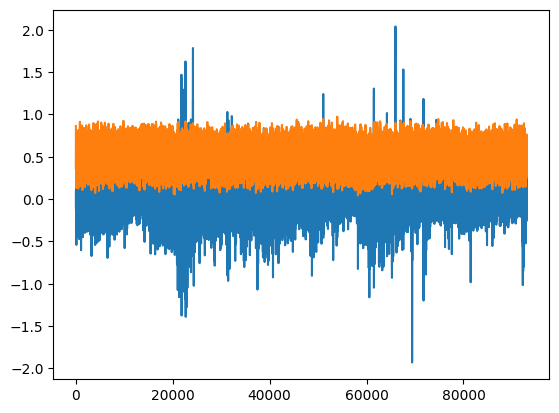

In [8]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [9]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [10]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [11]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [40]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(4)
    returns = np.array([])

    trade_timer = 0
    trade_value = 0
    trade_direction = 0
    cash_out_val = 0
    acount_bal = 10


    for count in range(rand, rand+1000):
        outputs = net.activate(INDICATORS[count])
        action = np.argmax(outputs)
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count]

        if buy:
          cash_out_val = trade_value
          trade_value = cur_move*1
          trade_direction = 1
          trade_timer = 0
        elif sell:
          cash_out_val = trade_value
          trade_value = cur_move*-1
          trade_direction = -1
          trade_timer = 0
        elif cash_out:
          cash_out_val = trade_value
          trade_value = 0
          trade_direction = 0
          trade_timer = 0
        else:
          trade_value += cur_move*trade_direction
          trade_timer += .05


        acount_bal += cash_out_val
        acount_bal += -.1


        trade_info = [trade_value,trade_direction,trade_timer,acount_bal]


        if debug:
          print(trade_info)

        if acount_bal<0:
          return count-rand


    return count

In [37]:
def eval_genomes(genomes, config):
  rand = random.randint(0, 70000)
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False)


In [38]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_dir)

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [39]:
winner = p.run(eval_genomes,100)


 ****** Running generation 0 ****** 

Population's average fitness: 2475.27333 stdev: 7211.59849
Best fitness: 24109.00000 - size: (4, 8) - species 1 - id 1

Best individual in generation 0 meets fitness threshold - complexity: (4, 8)


In [34]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [35]:
run_env_loop(net,70000,True)

[0, 0, 0, 9.9]
[0, 0, 0, 9.8]
[0, 0, 0, 9.700000000000001]
[0, 0, 0, 9.600000000000001]
[0, 0, 0, 9.500000000000002]
[0, 0, 0, 9.400000000000002]
[0, 0, 0, 9.300000000000002]
[0, 0, 0, 9.200000000000003]
[0, 0, 0, 9.100000000000003]
[0, 0, 0, 9.000000000000004]
[0, 0, 0, 8.900000000000004]
[0, 0, 0, 8.800000000000004]
[0, 0, 0, 8.700000000000005]
[0, 0, 0, 8.600000000000005]
[0, 0, 0, 8.500000000000005]
[0, 0, 0, 8.400000000000006]
[0, 0, 0, 8.300000000000006]
[0, 0, 0, 8.200000000000006]
[0, 0, 0, 8.100000000000007]
[0, 0, 0, 8.000000000000007]
[0, 0, 0, 7.9000000000000075]
[0, 0, 0, 7.800000000000008]
[0, 0, 0, 7.700000000000008]
[0, 0, 0, 7.6000000000000085]
[0, 0, 0, 7.500000000000009]
[0.6828501019215482, -1, 0, 7.400000000000009]
[0, 0, 0, 7.982850101921558]
[0, 0, 0, 7.882850101921559]
[0.5802996421143313, -1, 0, 7.782850101921559]
[0, 0, 0, 8.263149744035891]
[0, 0, 0, 8.163149744035891]
[0, 0, 0, 8.063149744035892]
[0, 0, 0, 7.963149744035892]
[0, 0, 0, 7.863149744035892]
[0, 

70327

In [ ]:


def get_weights(connections, node_name,letter):
    node_weight = ""

    for key, value in connections.items():
        if value.enabled:
            if node_name == letter[value.key[1]]:
                if value.key[0] < 0:
                    from_node_name = "P" + str(value.key[0] * -1)
                    weight = value.weight
                else:
                    from_node_name = letter[value.key[0]]
                    weight = value.weight
                node_weight = node_weight + from_node_name + " * " + str(weight) + " + "


    return(node_weight)





In [ ]:
nodes = winner.nodes
conec = winner.connections
node_list = []
letter_dict = dict()
count = 0



for index, node in nodes.items():
    letter_dict[index] = string.ascii_uppercase[count]
    count += 1

for index, node in nodes.items():
    node_name = letter_dict[index]
    activation = node.activation
    bias = str(node.bias) + ")"
    front = node_name + " = " + activation + "("
    weights = get_weights(conec,node_name,letter_dict)
    node_list.append((front+weights+bias))

node_list.reverse()






In [ ]:
print(winner)

Key: 7604
Fitness: 39.5992013093501
Nodes:
	0 DefaultNodeGene(key=0, bias=0.040860372320391844, response=1.0, activation=identity, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-2.4304265398230833, response=1.0, activation=abs, aggregation=sum)
	603 DefaultNodeGene(key=603, bias=-0.7377609977359878, response=1.0, activation=abs, aggregation=sum)
	606 DefaultNodeGene(key=606, bias=1.6444411532967487, response=1.0, activation=identity, aggregation=sum)
	607 DefaultNodeGene(key=607, bias=0.8025720723073365, response=1.0, activation=abs, aggregation=sum)
	608 DefaultNodeGene(key=608, bias=-0.9721775320973074, response=1.0, activation=abs, aggregation=sum)
	611 DefaultNodeGene(key=611, bias=1.7225460985763466, response=1.0, activation=abs, aggregation=sum)
	2990 DefaultNodeGene(key=2990, bias=-0.3179116165217865, response=1.0, activation=relu, aggregation=sum)
	3041 DefaultNodeGene(key=3041, bias=0.5474211028748757, response=1.0, activation=relu, aggregation=sum)
Connections:
	DefaultConn

In [ ]:
for item in node_list:
       print(item)

I = relu(P1 * 1.9319062315476767 + H * 0.8415230280414117 + 0.5474211028748757)
H = relu(P2 * 0.37733104827453345 + -0.3179116165217865)
G = abs(1.7225460985763466)
F = abs(P2 * 2.752470078657781 + I * 0.6381712072630762 + -0.9721775320973074)
E = abs(G * -2.1194013010028017 + P2 * 0.46884834168093004 + 0.8025720723073365)
D = identity(P2 * 1.1191686921634076 + H * 3.9513831135425113 + B * 1.6536591788097703 + 1.6444411532967487)
C = abs(P1 * 0.6320701976923242 + P2 * 0.8517532705477244 + D * -0.7749555067716818 + -0.7377609977359878)
B = abs(E * -1.447717383921146 + F * -1.5838456978397466 + P1 * 1.4149285592498657 + -2.4304265398230833)
A = identity(P1 * -5.332177219676623 + 0.040860372320391844)
